In [761]:
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.plotting import plot_efficient_frontier
import matplotlib.pyplot as plt
from pypfopt.discrete_allocation import DiscreteAllocation
from matplotlib.ticker import FuncFormatter
import os
import matplotlib.ticker as mticker
import warnings

# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

from dotenv.main import load_dotenv
load_dotenv(override=True)

True

In [762]:
frac_liabilities = float(os.getenv('FRAC_LIABILITIES'))
assets0 = 1000000
liabilities0 = assets0 * frac_liabilities

In [763]:
duration_lower_bound, duration_upper_bound = float(os.getenv("DUR_LOWERBOUND")), float(os.getenv("DUR_UPPERBOUND"))

In [764]:
from matplotlib import rc

# Set Times New Roman font globally
rc('font', family='serif', serif='Times New Roman')
plt.rcParams.update({'font.size': 14})
rc('mathtext', fontset='custom', rm='Times New Roman')

In [765]:
df = pd.read_csv('../../data/final_asset_classes.csv', index_col=0)
df.index = pd.to_datetime(df.index)

In [766]:
df.head()

,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2005-10-10,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000163
2005-10-11,1.003231,1.006833,1.004578,0.998658,0.998084,0.995925,1.000217
2005-10-12,0.999670,0.997110,0.996675,0.996056,0.996517,0.991573,1.000275
2005-10-13,0.981077,0.986449,0.997260,0.993734,0.993465,0.988179,1.000333
2005-10-14,0.973370,0.987997,0.994278,0.993174,0.993525,0.989778,1.000390


In [767]:
asset_names = ['RE', 'PE', 'Equity', 'IG CB', 'GB', 'HY CB', 'Money']

In [768]:
t1 = ("2021-11-01", "2022-11-01")
t2 = ("2007-06-01", "2008-06-01")
t3 = ("2022-11-01", "2023-11-01")

t = [t1,t2,t3]

In [769]:
scenarios = {
    "2007-06-01varnormal" : "A1",
    "2007-06-01cvarnormal" : "A2",
    "2007-06-01vartstudent" : "A3",
    "2007-06-01cvartstudent" : "A4",
    "2021-11-01varnormal" : "B1",
    "2021-11-01cvarnormal" : "B2",
    "2021-11-01vartstudent" : "B3",
    "2021-11-01cvartstudent" : "B4",
    "2022-11-01varnormal" : "C1",
    "2022-11-01cvarnormal" : "C2",
    "2022-11-01vartstudent" : "C3",
    "2022-11-01cvartstudent" : "C4",
}

## Loading Bounds

In [770]:

bounds = {}
asset_columns = df.columns

for asset in asset_columns:
    bound_str = os.getenv(f"CONCENTRATION_BOUNDS_{asset.upper()}")
    if bound_str:  # Only add if bounds are defined in the .env file
        lower_bound, upper_bound = map(float, bound_str.split(','))
        bounds[asset] = (lower_bound, upper_bound)

bounds_dict = bounds
print(bounds_dict)

bounds = [bounds_dict[col] for col in df.columns]
bounds


{'REEL': (0.0, 0.25), 'PE': (0.0, 0.2), 'MSCIWORLD': (0.0, 0.2), 'IG': (0.1, 1.0), 'GOV': (0.2, 1.0), 'HY': (0.05, 0.2), 'EONIA': (0.0, 1.0)}


[(0.0, 0.25),
 (0.0, 0.2),
 (0.0, 0.2),
 (0.1, 1.0),
 (0.2, 1.0),
 (0.05, 0.2),
 (0.0, 1.0)]

## Loading Durations

In [771]:
durations = {}
asset_columns = df.columns

for asset in asset_columns:
    dur_str = os.getenv(f"DUR_{asset.upper()}")
    if dur_str:  
        duration = float(dur_str)
        durations[asset] = duration
    else:
        durations[asset] = 0.0

duration_dict = durations

## Loading EONIA yearly

In [772]:
eonia_df = pd.read_csv('../../data/final_eonia/eonia_ann_rate.csv', index_col=0)
eonia_df.index = pd.to_datetime(eonia_df.index)

### Comparing with NSGA-II algorithm

In [773]:
import json
import numpy as np

def load_pareto_fronts(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)
    
    all_runs = []
    for entry in data:
        pareto_front = []
        for solution in entry.get("solutions", []):
            # Ensure solution is a dictionary
            if isinstance(solution, dict):
                weights = np.array(solution.get("weights", []))
                period = solution.get("period", [])
                cov_matrix = df[(df.index <= period[0])].cov()
                expected_return = solution.get("expected_return", 0) / 1000000
                
                std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) if weights.size > 0 else 0
                pareto_front.append({
                    "weights": weights.tolist(),  # Convert numpy array to list for JSON compatibility
                    "expected_return": expected_return,
                    "SCR_risk": solution.get("SCR_risk", 0),
                    "risk_measure": solution.get("risk_measure", ""),
                    "distribution": solution.get("distribution", ""),
                    "period": period,
                    "std_dev": std_dev  # Add standard deviation
                })
        all_runs.append(pareto_front)
    return all_runs

json_file_path = "../pareto_front_results.json"
pareto_fronts = load_pareto_fronts(json_file_path)

In [774]:
def plot_pareto_and_vanilla_mvo(pareto_fronts, df):

    mu = mean_historical_return(df)
    S = CovarianceShrinkage(df).ledoit_wolf()
    last_date = df.index[-1]
    
    risk_free_rate = eonia_df.loc[last_date] / 100

    print("RISK FREE RATE =", risk_free_rate)

    fig, ax = plt.subplots(figsize=(15, 8))

    cmap = plt.cm.get_cmap("tab10", len(pareto_fronts))  # Use 'tab10' colormap for distinct colors

    legend_items = {}

    for i, pareto_front in enumerate(pareto_fronts):

        weights_list = [np.array(solution["weights"]) for solution in pareto_front]
        expected_returns = [(solution["expected_return"])  for solution in pareto_front]
        std_devs = [(solution["std_dev"]) for solution in pareto_front]
        end_test_period = pareto_front[0]["period"][0]
        risk_measure = pareto_front[0]["risk_measure"]
        distribution = pareto_front[0]["distribution"]

        scenario = end_test_period + risk_measure + distribution

        scenario = scenarios[scenario]

        color = cmap(i)

        scatter = ax.scatter(std_devs, expected_returns, label=scenario, color=color, alpha=0.7)

        legend_items[scenario] = scatter

    ef_unconstrained = EfficientFrontier(mu, S) 
    plot_efficient_frontier(ef_unconstrained, ax=ax, show_assets=False)
    ef_vanilla = EfficientFrontier(mu, S)  # Create a new instance
    for i, asset in enumerate(df.columns):
        lower_bound, upper_bound = bounds_dict[asset]
        ef_vanilla.add_constraint(lambda w, i=i: w[i] >= lower_bound)  
        ef_vanilla.add_constraint(lambda w, i=i: w[i] <= upper_bound) 
        
    ef_vanilla.add_constraint(
        lambda w: sum(w[i] * durations[asset] for i, asset in enumerate(df.columns)) >= duration_lower_bound
    )

    ef_vanilla.add_constraint(
        lambda w: sum(w[i] * durations[asset] for i, asset in enumerate(df.columns)) <= duration_upper_bound
    )

    plot_efficient_frontier(ef_vanilla, ax=ax, show_assets=False)

    ef_max_sharpe = EfficientFrontier(mu, S)  
    for i, asset in enumerate(df.columns):
        lower_bound, upper_bound = bounds_dict[asset]
        ef_max_sharpe.add_constraint(lambda w, i=i: w[i] >= lower_bound)  
        ef_max_sharpe.add_constraint(lambda w, i=i: w[i] <= upper_bound) 

    ef_max_sharpe.add_constraint(
    lambda w: sum(w[i] * durations[asset] for i, asset in enumerate(df.columns)) >= duration_lower_bound
    )

    ef_max_sharpe.add_constraint(
        lambda w: sum(w[i] * durations[asset] for i, asset in enumerate(df.columns)) <= duration_upper_bound
    )
    weights = ef_max_sharpe.max_sharpe(risk_free_rate=risk_free_rate)  
    cleaned_weights = ef_max_sharpe.clean_weights()
    ret, vol, sharpe = ef_max_sharpe.portfolio_performance(verbose=True)

    # Output weights
    w1 = []
    print("Optimal weights for the Max Sharpe Ratio portfolio (CONSTRAINED MVO):")
    for asset, weight in cleaned_weights.items():
        w1.append(weight)
        print(f"{asset}: {weight:.2%}")
    ax.scatter(vol, ret, marker=".", color="orange", s=400, label="Constrained MVO Max Sharpe Portfolio", zorder=10)

    ef_max_sharpe_unconstrained = EfficientFrontier(mu, S)  
    weights = ef_max_sharpe_unconstrained.max_sharpe(risk_free_rate=risk_free_rate)  
    cleaned_weights = ef_max_sharpe_unconstrained.clean_weights()
    ret, vol, sharpe = ef_max_sharpe_unconstrained.portfolio_performance(verbose=True)

    # Output weights
    print("Optimal weights for the Max Sharpe Ratio portfolio (UNCONSTRAINED MVO):")
    w2 = []
    for asset, weight in cleaned_weights.items():
        w2.append(weight)
        print(f"{asset}: {weight:.2%}")
    ax.scatter(vol, ret, marker=".", color="b", s=400, label="Unconstrained MVO Max Sharpe Portfolio", zorder=10)

    asset_vols = np.sqrt(np.diag(S))

    for i, asset in enumerate(asset_names):
        ax.scatter((asset_vols[i]), (mu[i]), color="black", s=50, zorder=5)  
        ax.text(asset_vols[i]  + 0.006, mu[i] - 0.002, f" {asset}", fontsize=14, color="black", zorder=10)

    # Create the legend with sorted labels
    sorted_legend_items = sorted(legend_items.items(), key=lambda x: x[0])  # Sort by label (key)
    sorted_labels = [item[0] for item in sorted_legend_items]
    sorted_handles = [item[1] for item in sorted_legend_items]

    # Adding separate labels for Tangency portfolios
    tangency_handles = [
        plt.Line2D([], [], color='b', marker='.', linestyle='None', markersize=10),
        plt.Line2D([], [], color='orange', marker='.', linestyle='None', markersize=10)

    ]
    tangency_labels = [
        "Tangency Portfolio (Unconstrained Max Sharpe)",
        "Tangency Portfolio (Constrained Max Sharpe)"
    ]

    # Combine everything into the legend
    ax.legend(
        sorted_handles + tangency_handles, 
        sorted_labels + tangency_labels, 
        fontsize=14, 
        frameon=False,
        loc='center left',  # Place the legend to the right of the plot
        bbox_to_anchor=(1.0, 0.5)
    )

    # Customize the plot
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x*100:.1f}"))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y*100:.1f}"))
    plt.xlabel(r"$\sigma_p$ (%)")
    plt.ylabel(r"$r_p$ (%)")
    plt.tight_layout()
    plt.show()

    return w1, w2

TIME PERIOD: ('2021-11-01', '2022-11-01')
RISK FREE RATE = Rate   -0.00579
Name: 2021-11-01 00:00:00, dtype: float64


/Users/nickaskari/Desktop/Prosjektoppgave/portfolio-opt-insurance/packages/lib/python3.12/site-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
/var/folders/h4/_4wngf5n4793mylk022tqrrh0000gn/T/ipykernel_17294/4022830315.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(pareto_fronts))  # Use 'tab10' colormap for distinct colors


ValueError: risk_free_rate should be numeric

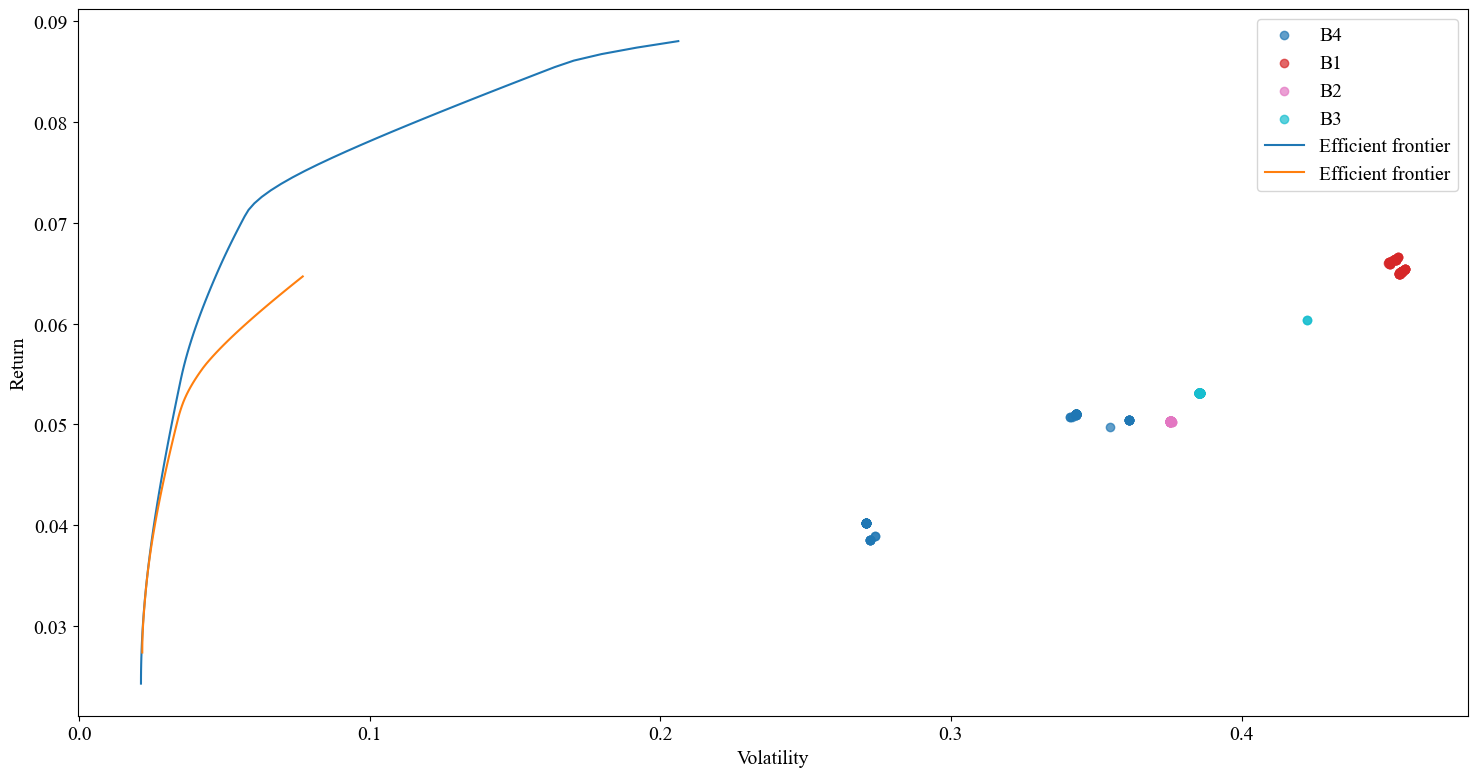

In [775]:
solutions = {}
# W1 = constrined
for i in t:
    new_df = df[(df.index <= i[0])]
    print("TIME PERIOD:", i)
    valid_pareto_fronts = []

    for pareto_front in pareto_fronts:
        portfolio = pareto_front[0]
        start_test_period = portfolio["period"][0]

        if i[0] == start_test_period:
            valid_pareto_fronts.append(pareto_front)
            continue
        
    w1, w2 = plot_pareto_and_vanilla_mvo(valid_pareto_fronts, new_df)
    solutions[i] = (w1, w2)

## For all of the 3 Time Periods Compute SCR For each config

In [ ]:
solutions

{('2021-11-01',
  '2022-11-01'): ([0.0, 0.0, 0.0464, 0.31691, 0.2119, 0.2, 0.22479], [0.0,
   0.0,
   0.02886,
   0.27325,
   0.21055,
   0.32887,
   0.15847]),
 ('2007-06-01',
  '2008-06-01'): ([0.08577, 0.2, 0.16531, 0.14891, 0.2, 0.2, 0.0], [0.09634,
   0.35891,
   0.21346,
   0.04706,
   0.0,
   0.22013,
   0.06409]),
 ('2022-11-01',
  '2023-11-01'): ([0.0, 0.0, 0.05337, 0.24996, 0.2, 0.2, 0.29667], [0.0,
   0.0,
   0.03045,
   0.20891,
   0.15563,
   0.37579,
   0.22921])}

In [ ]:
import sys
sys.path.append('../')

from models.distribution_calculator import DistributionCalculator

df = pd.read_csv('../../data/final_daily_returns_asset_classes.csv', index_col=0)
df.index = pd.to_datetime(df.index)

In [ ]:
def calculate_scr(weights, simulated_daily_returns, simulated_cumulative_lg, risk_measure):
    weights = np.asarray(weights)  
    BOF_0 = assets0 - liabilities0
    portfolio_returns = np.dot(simulated_daily_returns, weights)
    simulated_cumulative_returns = np.cumprod(1 + portfolio_returns, axis=1)[:, -1] - 1
    assets_t1 = assets0 * (1 + simulated_cumulative_returns)


    liabilities_t1 = liabilities0 * (1 + simulated_cumulative_lg)

    bof_t1 = assets_t1 - liabilities_t1
    bof_change = bof_t1 - BOF_0
    var = np.percentile(bof_change, 100 * (1 - 0.995))

    if risk_measure == 'var':  
        scr = var
    elif risk_measure == 'cvar':
        cvar = np.mean(bof_change[bof_change <= var])
        scr = cvar
    else:
        raise SystemExit("Invalid risk measure:", risk_measure)

    return abs(scr)

In [ ]:
risk_measures = ['var', 'cvar']
dists = ['normal', 'tstudent']

final_solutions = []

In [ ]:
# Constrined, unconcstrained

In [ ]:
for t in solutions.keys():
    new_df = df[(df.index <= t[0])]

    w1, w2 = solutions[t][0], solutions[t][1]
    for risk_measure in risk_measures:
        for d in dists:
            dist = DistributionCalculator(new_df)
            simulated_daily_returns, simulated_cumulative_returns = dist.prefered_dist(custom = d)
            simulated_cumulative_lg = dist.prefered_liability_growth(custom=d)

            scr_1 = calculate_scr(w1, simulated_daily_returns, simulated_cumulative_lg, risk_measure)
            scr_2 = calculate_scr(w2, simulated_daily_returns, simulated_cumulative_lg, risk_measure)

            final_solutions.append({
                "weights" : w1,
                "SCR_risk" : scr_1,
                "risk_measure" : risk_measure,
                "distribution" : d,
                "period" : t,
                "Constrained" : True
            })

            final_solutions.append({
                "weights" : w2,
                "SCR_risk" : scr_2,
                "risk_measure" : risk_measure,
                "distribution" : d,
                "period" : t,
                "Constrained" : False
            })

In [ ]:
final_solutions

[{'weights': [0.0, 0.0, 0.0464, 0.31691, 0.2119, 0.2, 0.22479],
  'SCR_risk': np.float64(23827.00849888429),
  'risk_measure': 'var',
  'distribution': 'normal',
  'period': ('2021-11-01', '2022-11-01'),
  'Constrained': True},
 {'weights': [0.0, 0.0, 0.02886, 0.27325, 0.21055, 0.32887, 0.15847],
  'SCR_risk': np.float64(25757.59234221109),
  'risk_measure': 'var',
  'distribution': 'normal',
  'period': ('2021-11-01', '2022-11-01'),
  'Constrained': False},
 {'weights': [0.0, 0.0, 0.0464, 0.31691, 0.2119, 0.2, 0.22479],
  'SCR_risk': np.float64(170395.8414747177),
  'risk_measure': 'var',
  'distribution': 'tstudent',
  'period': ('2021-11-01', '2022-11-01'),
  'Constrained': True},
 {'weights': [0.0, 0.0, 0.02886, 0.27325, 0.21055, 0.32887, 0.15847],
  'SCR_risk': np.float64(232492.55080113583),
  'risk_measure': 'var',
  'distribution': 'tstudent',
  'period': ('2021-11-01', '2022-11-01'),
  'Constrained': False},
 {'weights': [0.0, 0.0, 0.0464, 0.31691, 0.2119, 0.2, 0.22479],
  'SC

## Now Plotting Compliance

--------------NEW PARETO FRONT--------------
Compliance = 0.0744594015590134
SCR = 23827.00849888429
Configuration: VaR with Gaussian


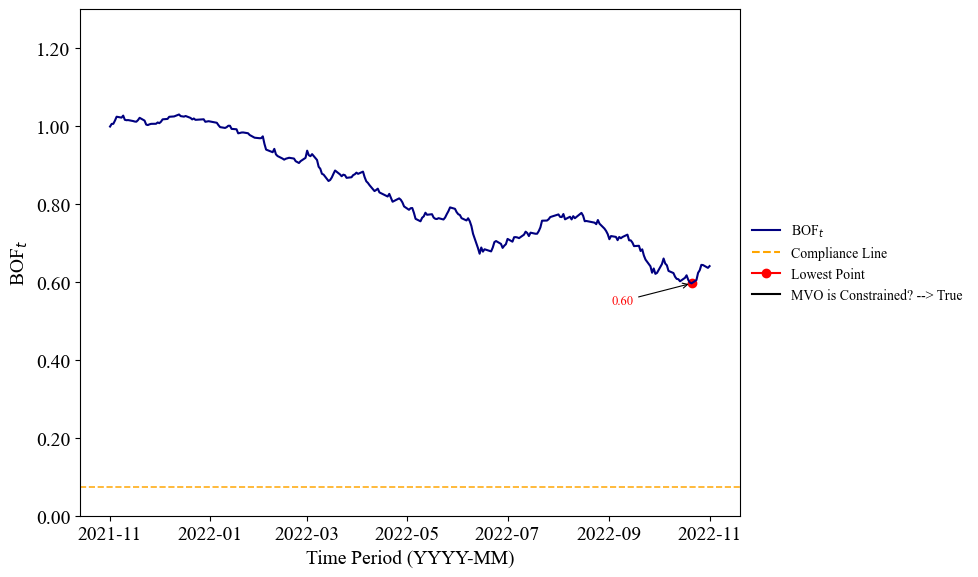

--------------NEW PARETO FRONT--------------
Compliance = 0.08049247606940965
SCR = 25757.59234221109
Configuration: VaR with Gaussian


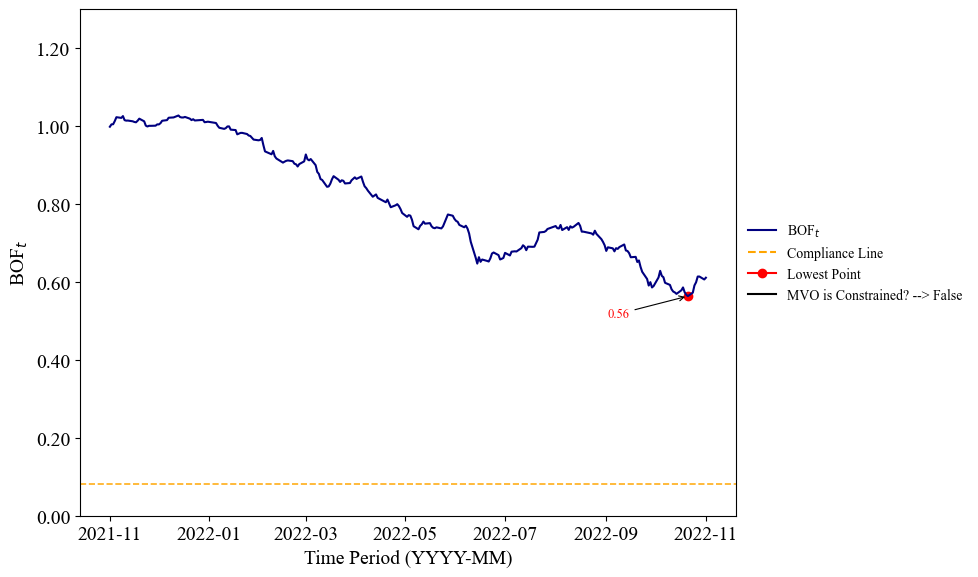

--------------NEW PARETO FRONT--------------
Compliance = 0.5324870046084927
SCR = 170395.8414747177
Configuration: VaR with t-Student


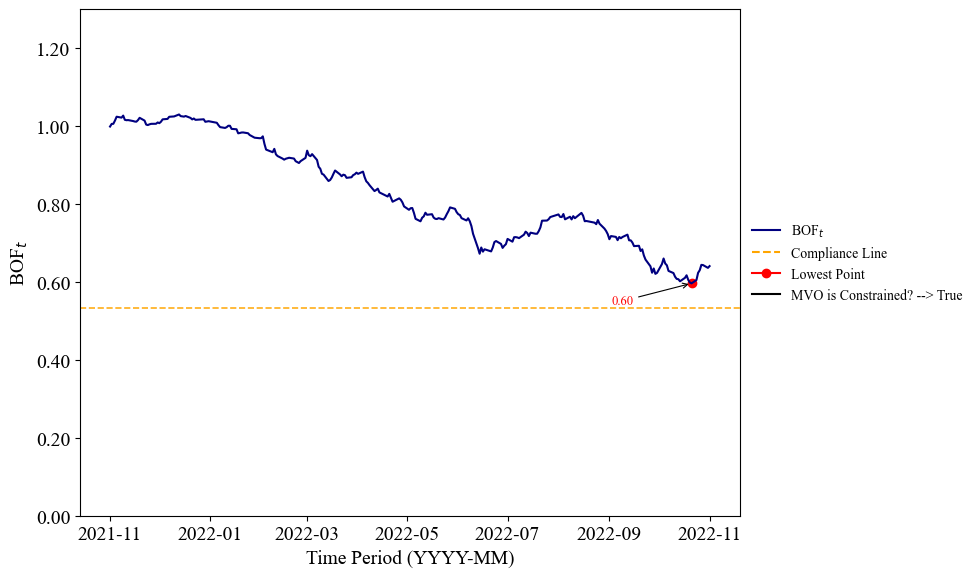

--------------NEW PARETO FRONT--------------
Compliance = 0.7265392212535495
SCR = 232492.55080113583
Configuration: VaR with t-Student


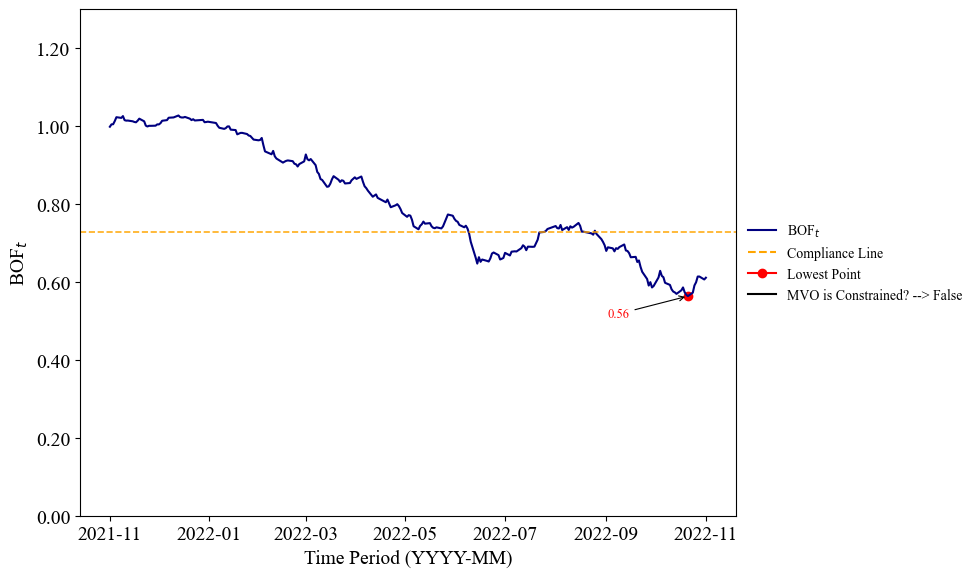

--------------NEW PARETO FRONT--------------
Compliance = 0.09921124909600029
SCR = 31747.599710720093
Configuration: CVaR with Gaussian


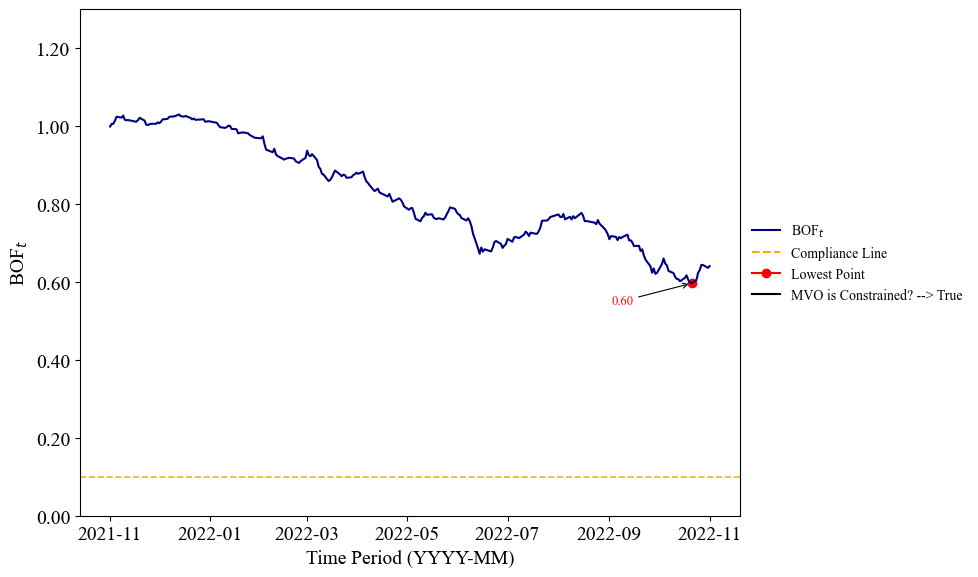

--------------NEW PARETO FRONT--------------
Compliance = 0.11123226349109591
SCR = 35594.32431715069
Configuration: CVaR with Gaussian


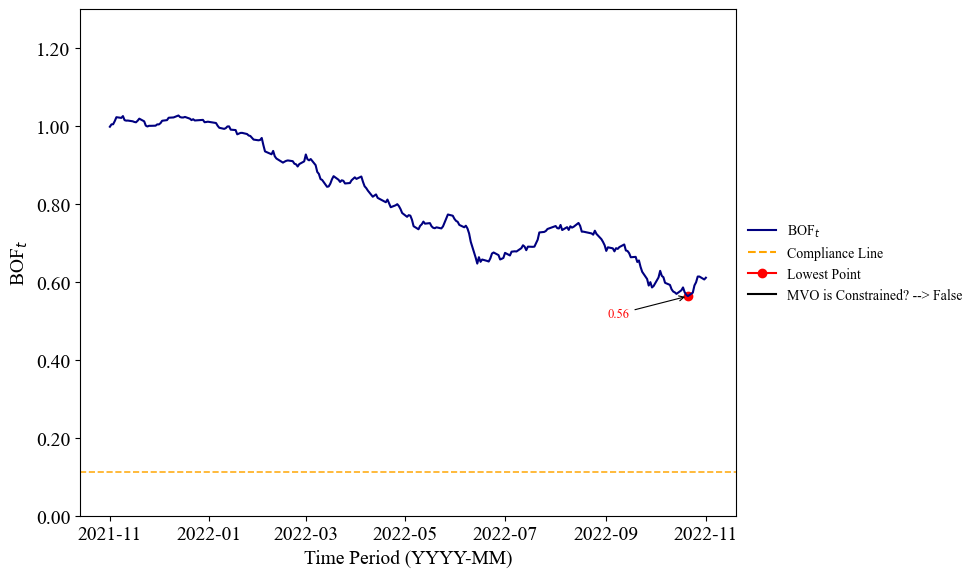

--------------NEW PARETO FRONT--------------
Compliance = 1.0035665912187113
SCR = 321141.3091899876
Configuration: CVaR with t-Student


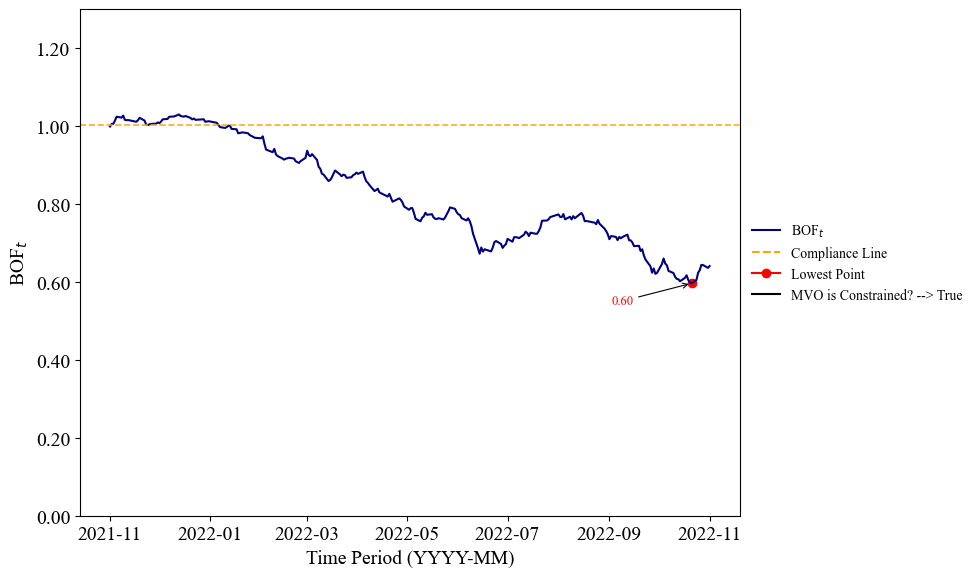

--------------NEW PARETO FRONT--------------
Compliance = 1.3134050180096593
SCR = 420289.60576309095
Configuration: CVaR with t-Student


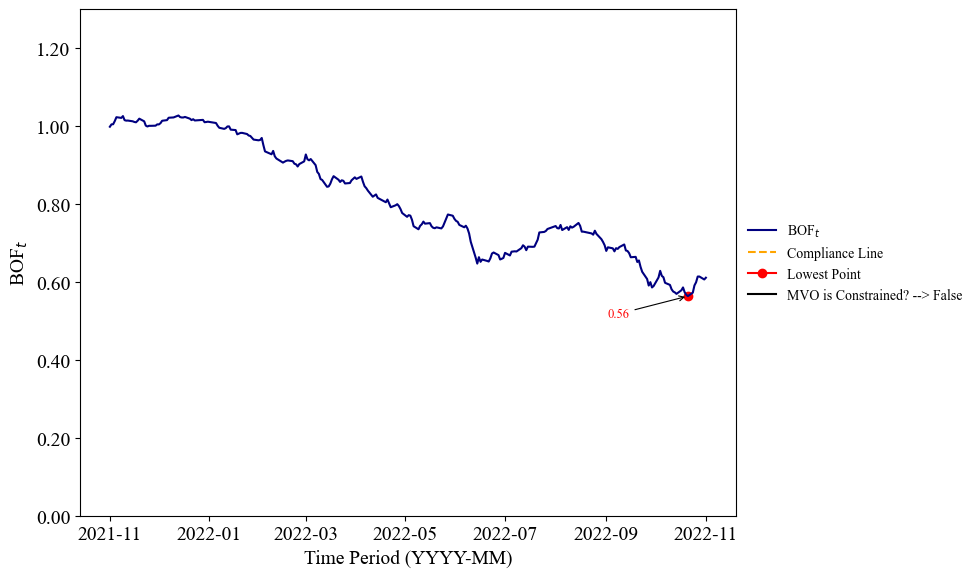

--------------NEW PARETO FRONT--------------
Compliance = 0.06825231140859375
SCR = 21840.73965075
Configuration: VaR with Gaussian


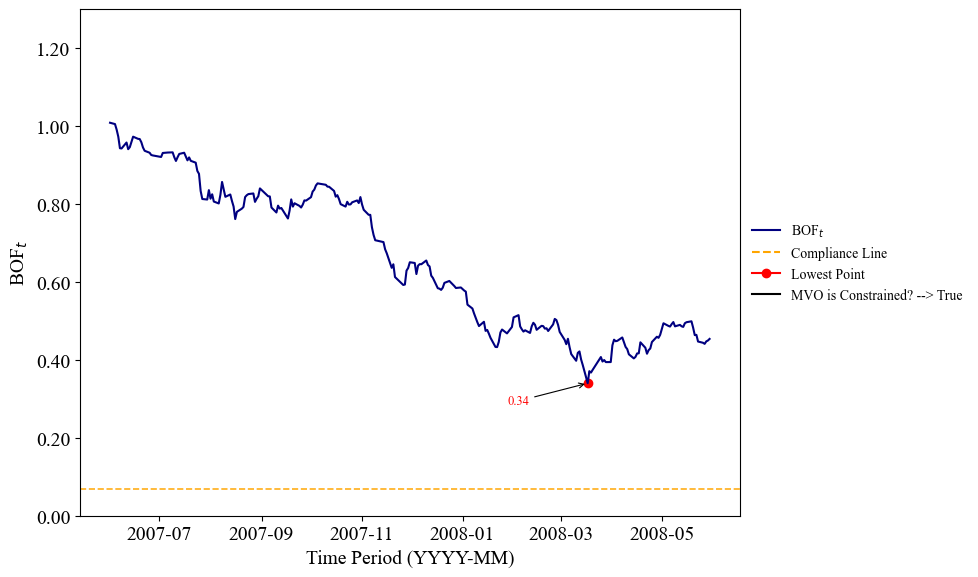

--------------NEW PARETO FRONT--------------
Compliance = 0.09287656091019948
SCR = 29720.499491263836
Configuration: VaR with Gaussian


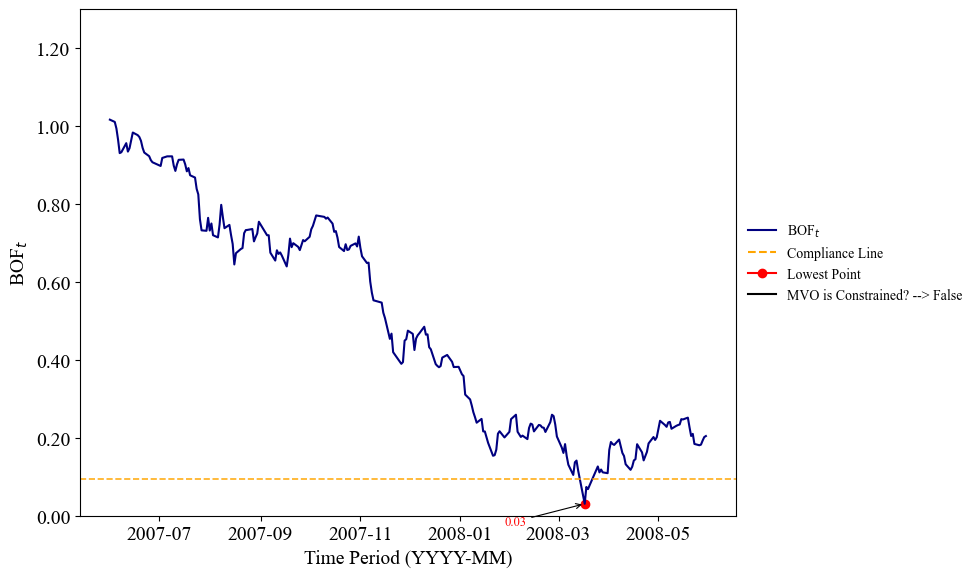

--------------NEW PARETO FRONT--------------
Compliance = 0.06620348459261186
SCR = 21185.115069635794
Configuration: VaR with t-Student


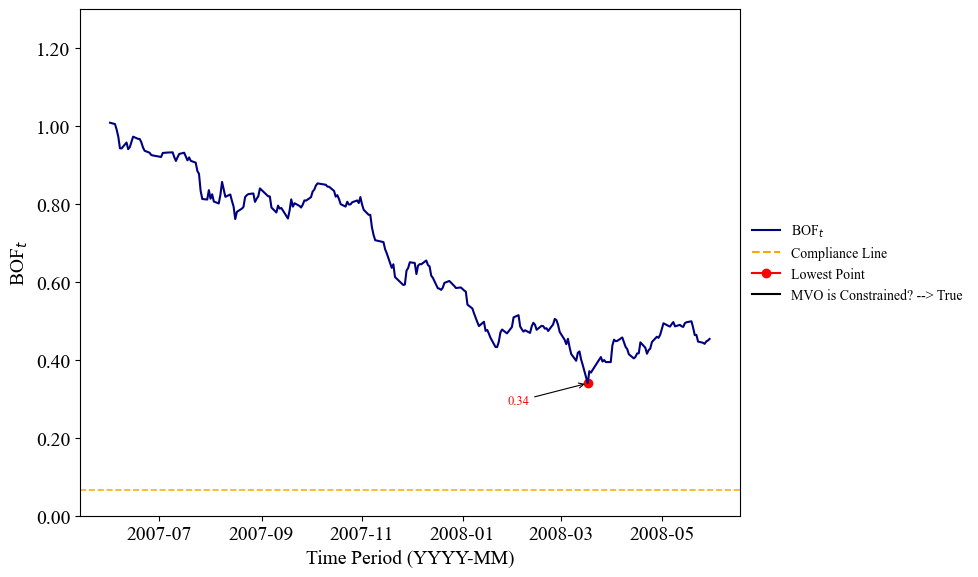

--------------NEW PARETO FRONT--------------
Compliance = 0.06945360397779693
SCR = 22225.15327289502
Configuration: VaR with t-Student


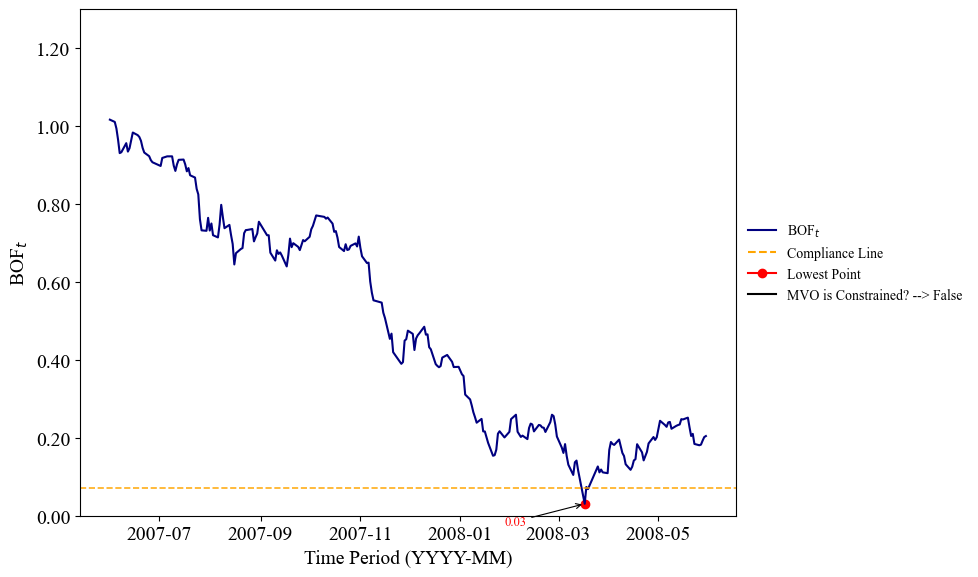

--------------NEW PARETO FRONT--------------
Compliance = 0.11580049002510377
SCR = 37056.15680803321
Configuration: CVaR with Gaussian


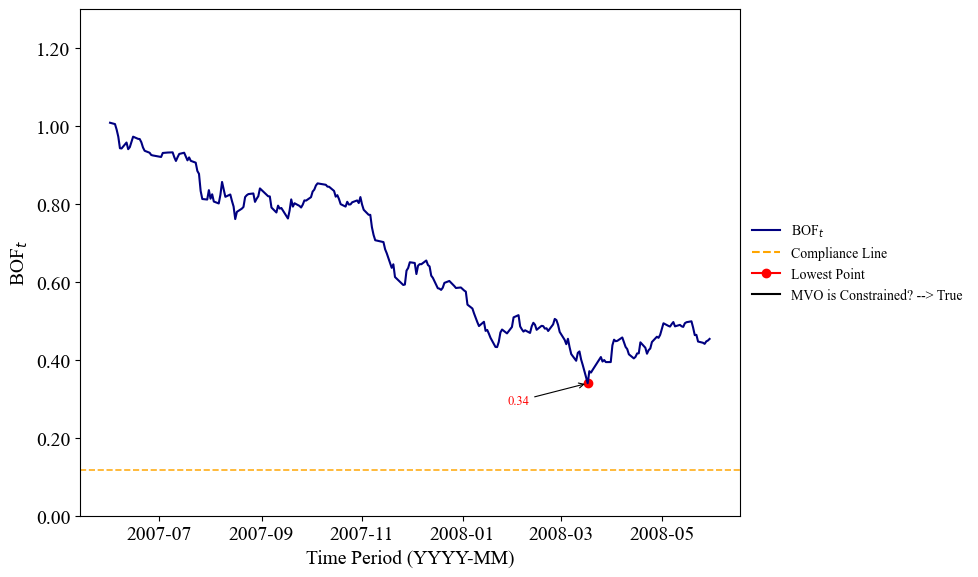

--------------NEW PARETO FRONT--------------
Compliance = 0.1601223680327314
SCR = 51239.15777047405
Configuration: CVaR with Gaussian


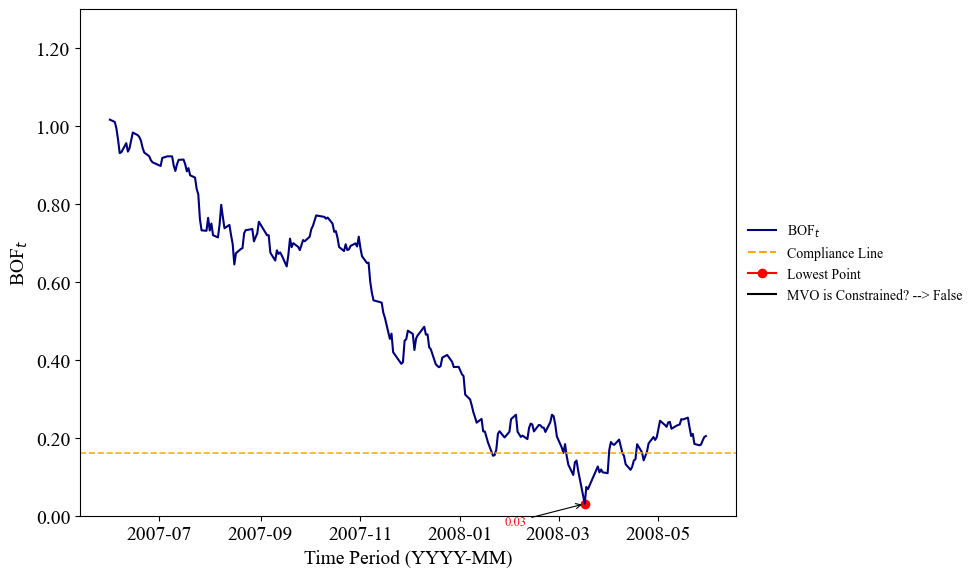

--------------NEW PARETO FRONT--------------
Compliance = 0.16821281603163102
SCR = 53828.101130121926
Configuration: CVaR with t-Student


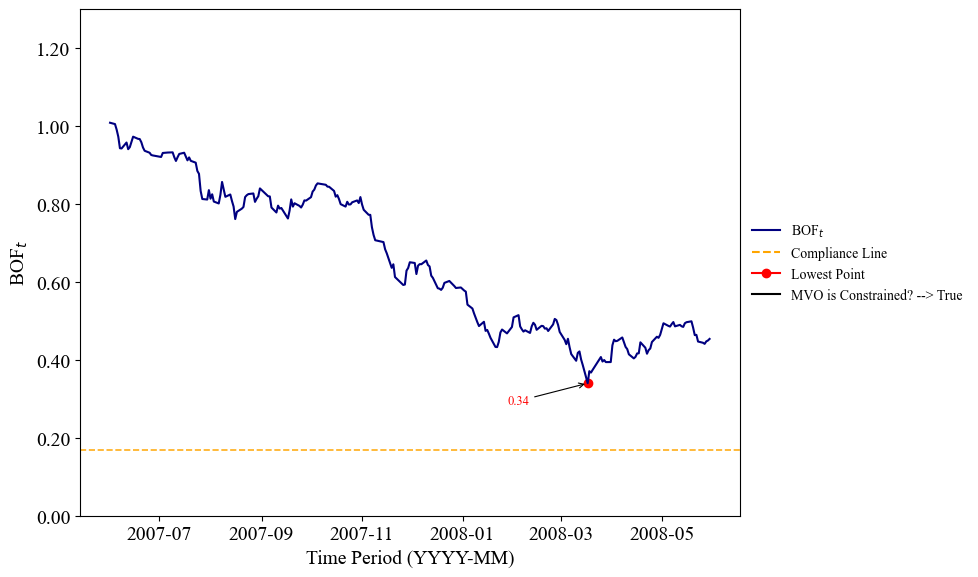

--------------NEW PARETO FRONT--------------
Compliance = 0.19891137427505495
SCR = 63651.63976801759
Configuration: CVaR with t-Student


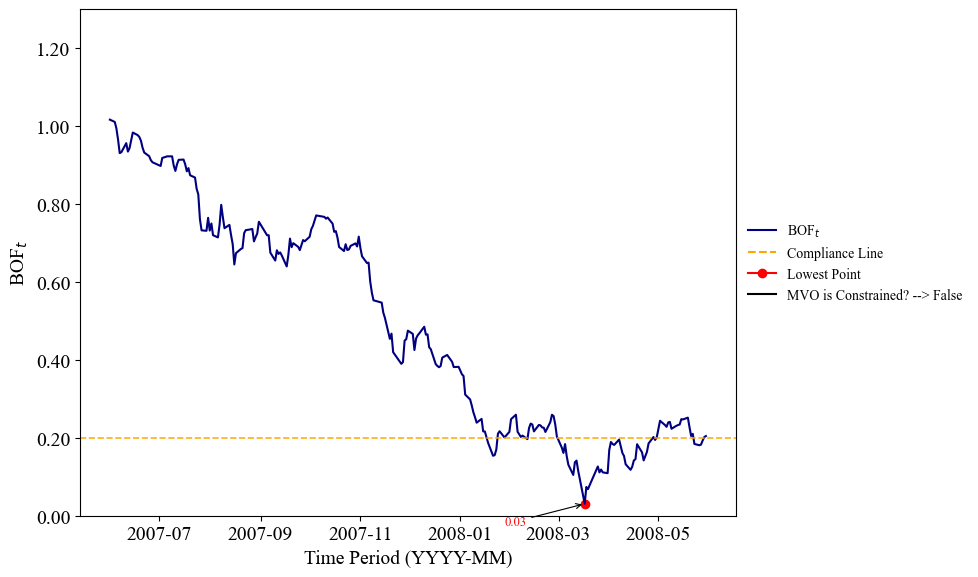

--------------NEW PARETO FRONT--------------
Compliance = 0.11180362012827402
SCR = 35777.158441047686
Configuration: VaR with Gaussian


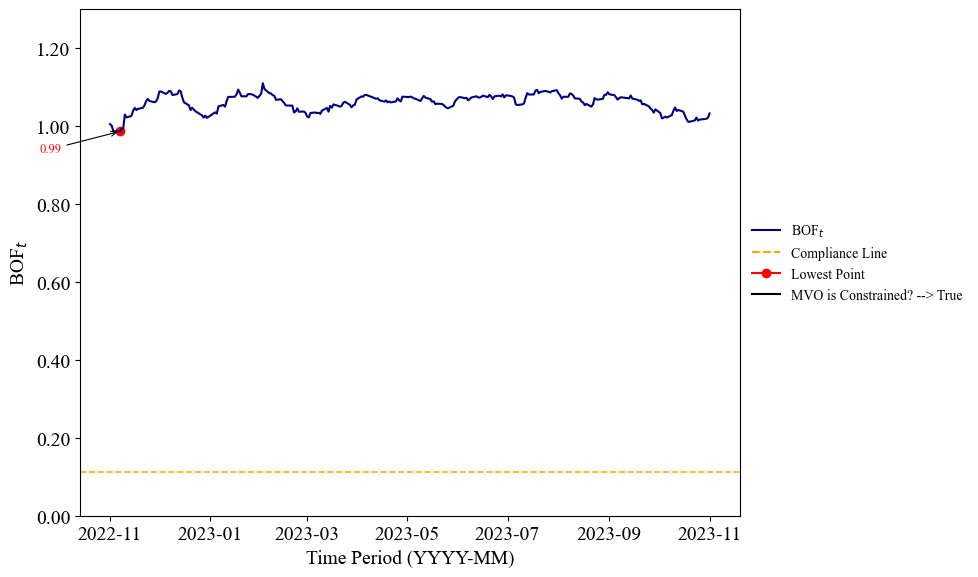

--------------NEW PARETO FRONT--------------
Compliance = 0.12260406079731499
SCR = 39233.2994551408
Configuration: VaR with Gaussian


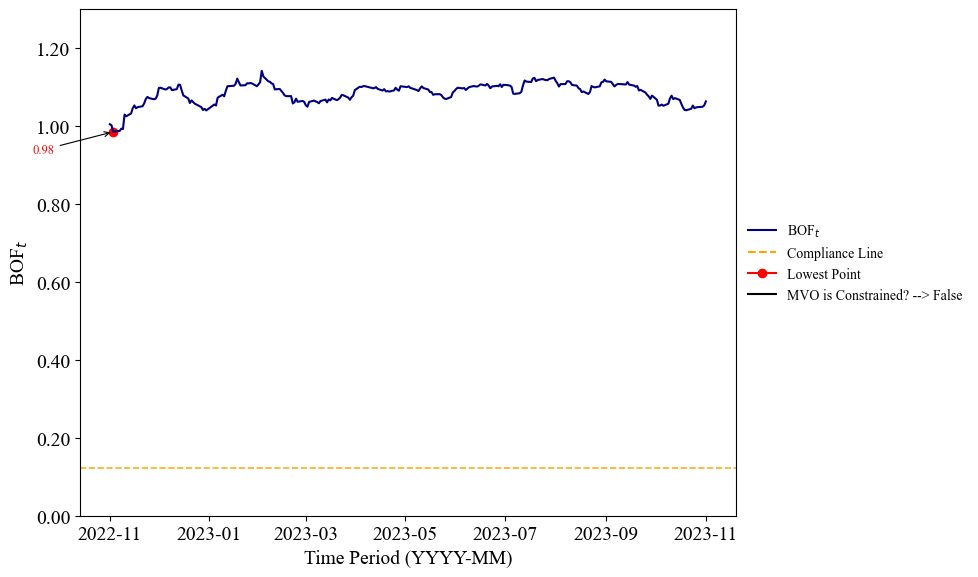

--------------NEW PARETO FRONT--------------
Compliance = 0.5702580524805545
SCR = 182482.57679377744
Configuration: VaR with t-Student


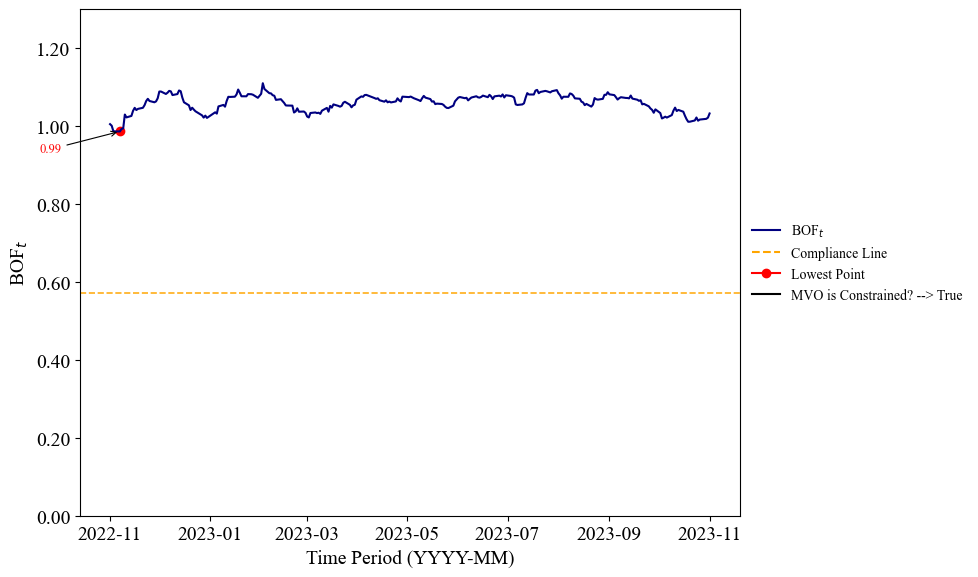

--------------NEW PARETO FRONT--------------
Compliance = 0.7005274036090697
SCR = 224168.76915490231
Configuration: VaR with t-Student


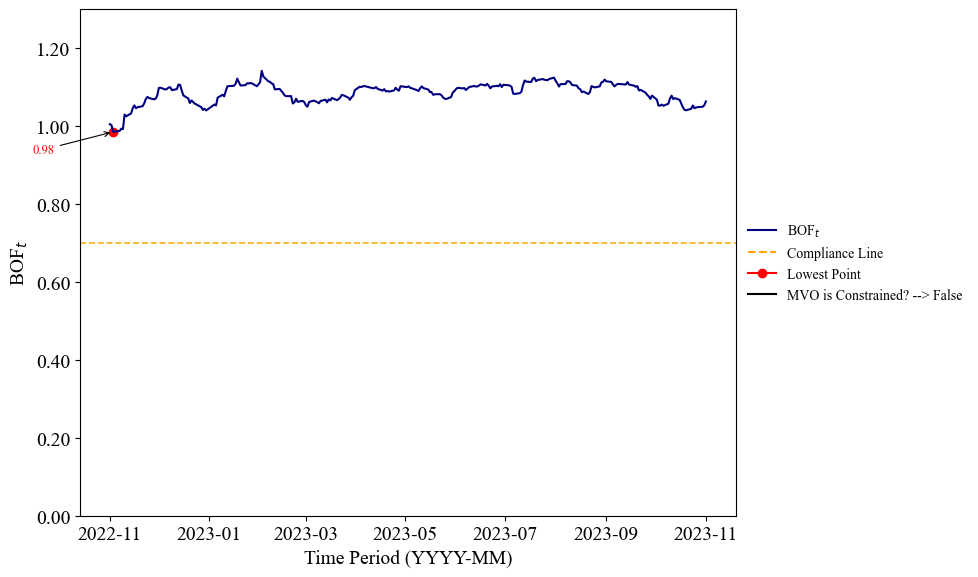

--------------NEW PARETO FRONT--------------
Compliance = 0.13296820301653706
SCR = 42549.82496529186
Configuration: CVaR with Gaussian


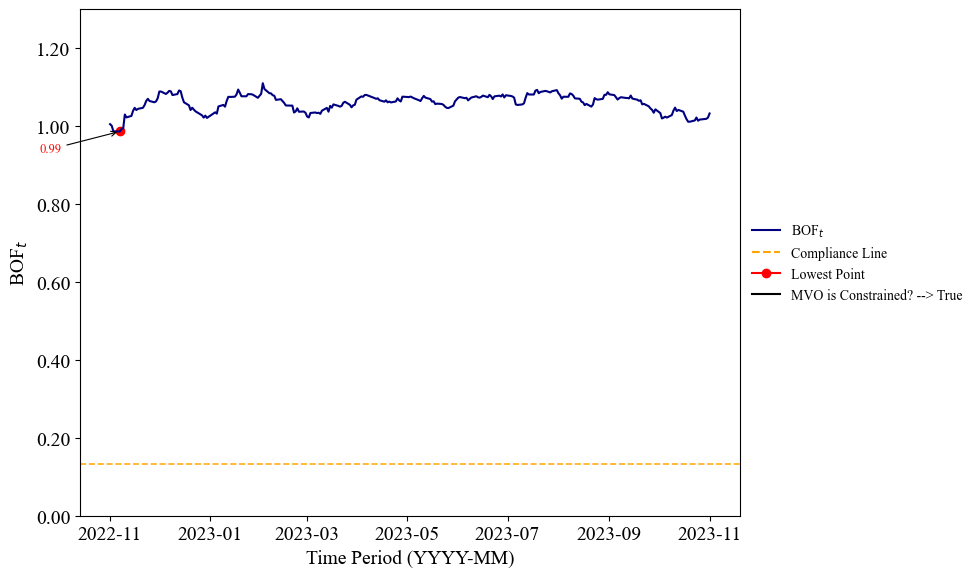

--------------NEW PARETO FRONT--------------
Compliance = 0.14890723288632363
SCR = 47650.31452362356
Configuration: CVaR with Gaussian


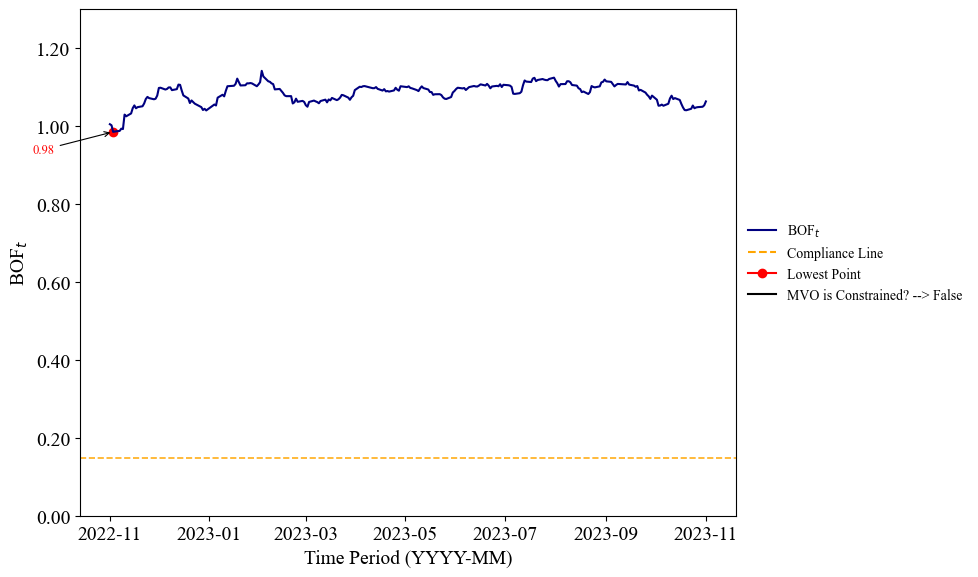

--------------NEW PARETO FRONT--------------
Compliance = 1.2884460823081267
SCR = 412302.7463386005
Configuration: CVaR with t-Student


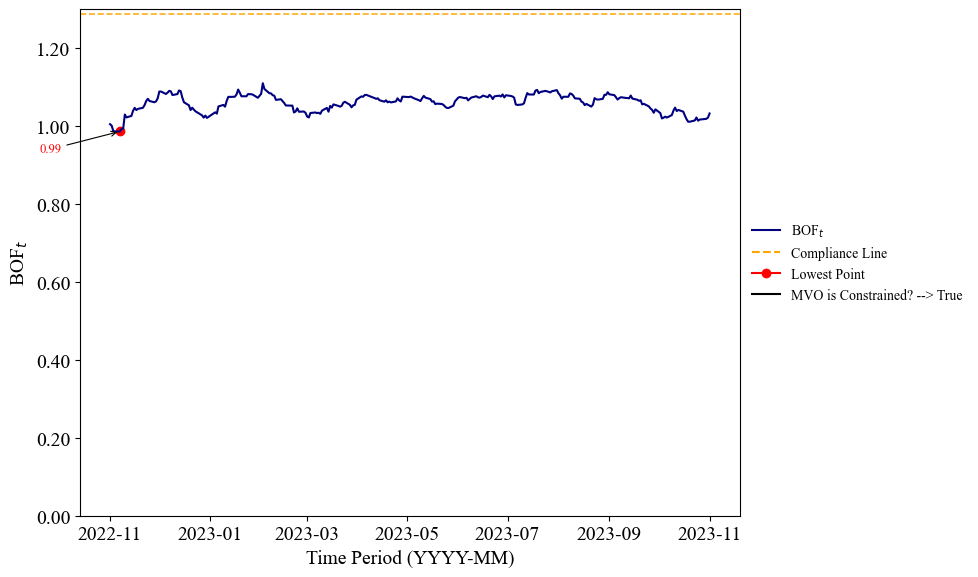

--------------NEW PARETO FRONT--------------
Compliance = 1.6526993343383518
SCR = 528863.7869882726
Configuration: CVaR with t-Student


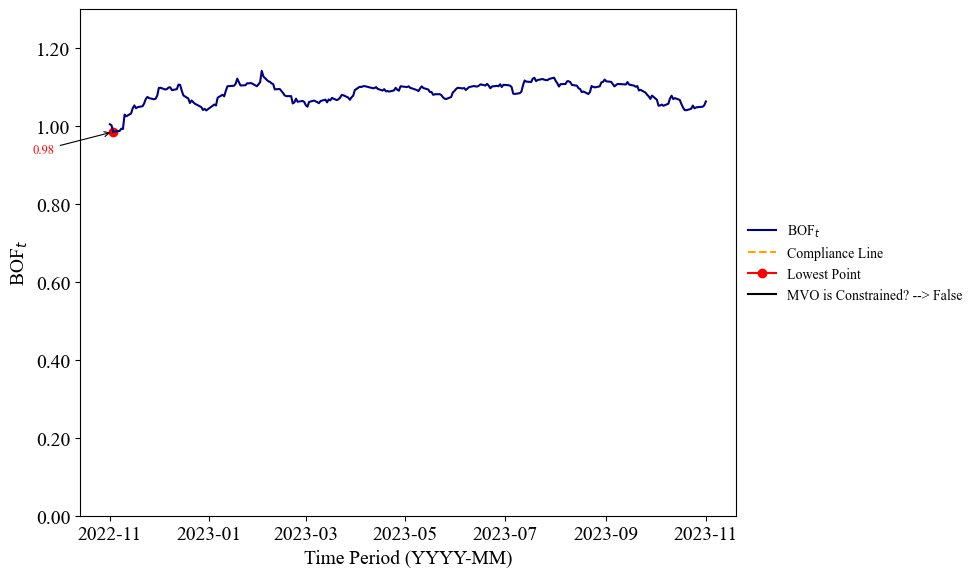

In [ ]:
for portfolio in final_solutions:
    print("--------------NEW PARETO FRONT--------------")
    i = 0
    bof_changes = []

    weights = portfolio["weights"]
    period = portfolio["period"]
    start_date = pd.to_datetime(
        period[0], format='%Y-%m-%d', errors='coerce')
    end_date = pd.to_datetime(
        period[1], format='%Y-%m-%d', errors='coerce')

    filtered_df = df[(df.index >= str(start_date))
                        & (df.index <= str(end_date))]

    for current_date in filtered_df.index:
        current_data = filtered_df.loc[:current_date]

        stock_returns = current_data
        eonia_returns = current_data["EONIA"]
        portfolio_returns = np.dot(stock_returns.values, weights)
        cumulative_portfolio_return = np.prod(1 + portfolio_returns) - 1

        cumulative_liability_growth = np.prod(1 + eonia_returns) - 1

        bof_1 = ((1 + cumulative_portfolio_return) * assets0) - \
            ((1+cumulative_liability_growth) * liabilities0)


        bof_t = bof_1 / (assets0 - liabilities0)

        bof_changes.append({
            "time": current_date,
            "final_bof": bof_t,
            "risk_measure": portfolio["risk_measure"]
        })

    bof_changes_df = pd.DataFrame(bof_changes)

    plt.figure(figsize=(10, 6))
    plt.plot(
        bof_changes_df["time"],
        bof_changes_df["final_bof"],
        color="navy", linewidth=1.5, label=r"$\Delta$ BOF_t"
    )

    min_bof_index = bof_changes_df["final_bof"].idxmin()
    min_bof_value = bof_changes_df.loc[min_bof_index, "final_bof"]
    min_bof_time = bof_changes_df.loc[min_bof_index, "time"]

    plt.scatter(min_bof_time, min_bof_value,
                color="red", label="Lowest Point")
    plt.annotate(
        f"{min_bof_value:,.2f}",
        (min_bof_time, min_bof_value),
        textcoords="offset points",
        xytext=(-50, -15),
        ha='center',
        fontsize=9,
        color="red",
        arrowprops=dict(facecolor='red', arrowstyle="->", lw=0.8)
    )

    compliance = portfolio['SCR_risk'] / (assets0 - liabilities0)
    print("Compliance =", compliance)
    plt.axhline(compliance, color="orange", linestyle="--", linewidth=1.2, alpha=0.9, label="Compliance Line")
    print(f"SCR = {portfolio['SCR_risk']}")

    plt.ylim(0, 1.32)
    plt.gca().yaxis.set_major_formatter(
        mticker.StrMethodFormatter('{x:,.2f}'))

    info_text = "\n".join([f"{key}: {value}" for key, value in portfolio.items(
    ) if key not in ["weights", "expected_return", "period"]])
    
    risk_measure_mapping = {
        "var": "VaR",
        "cvar": "CVaR"
    }

    distribution_mapping = {
        "normal": "Gaussian",
        "tstudent": "t-Student"
    }

    info = {
        "Risk Measure": risk_measure_mapping.get(portfolio["risk_measure"].lower(), portfolio["risk_measure"]),
        "Distribution": distribution_mapping.get(portfolio["distribution"].lower(), portfolio["distribution"])
    }

    info_legend_text = "\n".join(
        [f"{key}: {value}" for key, value in info.items()])
    
    is_constrained = portfolio["Constrained"]
    constraint_text = "MVO is Constrained? --> "+ str(is_constrained) 

    plt.legend(
        handles=[
            plt.Line2D([], [], color='navy', label=r"$\text{BOF}_t$"),
            plt.Line2D([], [], color='orange', linestyle="--",
                        label="Compliance Line"),
            plt.Line2D([], [], color='red', marker='o',
                        label="Lowest Point"),
            plt.Line2D([], [], color='black',
                label=constraint_text)
        ],
        loc='center left', 
        bbox_to_anchor=(1, 0.5),
        frameon=False,
        fontsize=10
    )

    title_text = f"Configuration: {info['Risk Measure']} with {info['Distribution']}"

    
    plt.xlabel("Time Period (YYYY-MM)")
    plt.ylabel(r"$\text{BOF}_t$", size=14)
    #plt.title(title_text, size=14)
    print(title_text)

    plt.grid(False)
    plt.tight_layout()
    plt.show()
    i += 1

In [ ]:
a = True
b = str(a) + "Yo"
b

'TrueYo'